<h1>  SHAP – Feature Importance & Explainability  </h1>

In [51]:
# !pip install "numpy<2.0" shap pymongo

In [53]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from pymongo import MongoClient
from dotenv import load_dotenv

# Load variables from .env file for local development
load_dotenv()

True

In [57]:
# Load Trained model
MODEL_PATH = "models/aqi_multi_output_model.pkl"

bundle = joblib.load(MODEL_PATH)
model = bundle["model"]
feature_cols = bundle["features"]
model_type = bundle.get("model_type", "UNKNOWN")

print(f"Loaded model type: {model_type}")
print(f"Number of features: {len(feature_cols)}")

Loaded model type: RF
Number of features: 39


In [59]:
# Use 24h horizon estimator
base_estimator = model.estimators_[0]

# load dataset
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = os.getenv("DB_NAME", "aqi_predictor")
COLLECTION_NAME = os.getenv("COLLECTION_NAME", "feature_store")

client = MongoClient(MONGO_URI)
df = pd.DataFrame(
    list(client[DB_NAME][COLLECTION_NAME].find({}, {"_id": 0}))
)

# Preprocessing
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.sort_values("datetime")
    df = df.drop(columns=["datetime"])

df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna()

X = df[feature_cols]

print(f"Dataset loaded for explainability: {X.shape}")

# Feature Importance
if not hasattr(base_estimator, "feature_importances_"):
    raise ValueError(
        f"{model_type} does not expose feature_importances_. "
        "Tree-based models required."
    )

importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": base_estimator.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 15 Important Features:")
print(importance_df.head(15))

print("\nBottom 10 Least Important Features:")
print(importance_df.tail(10))

Dataset loaded for explainability: (17952, 39)

Top 15 Important Features:
               feature  importance
21            pm25_log    0.104104
30               pm2_5    0.099857
24   pm25_roll_mean_3h    0.076982
15         pm25_lag_1h    0.067583
25   pm25_roll_mean_6h    0.044615
23  pm25_roll_mean_24h    0.039396
17         pm25_lag_2h    0.038455
0                   co    0.037036
22  pm25_roll_mean_12h    0.030264
16        pm25_lag_24h    0.030026
34         temperature    0.026033
19        pm25_lag_48h    0.025268
38              wind_y    0.022066
27   pm25_roll_std_24h    0.021015
18         pm25_lag_3h    0.018108

Bottom 10 Least Important Features:
              feature  importance
32   stagnation_index    0.013182
9          no2_lag_1h    0.013032
10         no2_lag_6h    0.012629
26  pm25_roll_std_12h    0.012502
36         wind_speed    0.010919
29   pm25_roll_std_6h    0.010570
28   pm25_roll_std_3h    0.009253
2            hour_sin    0.006239
1            hour_cos 

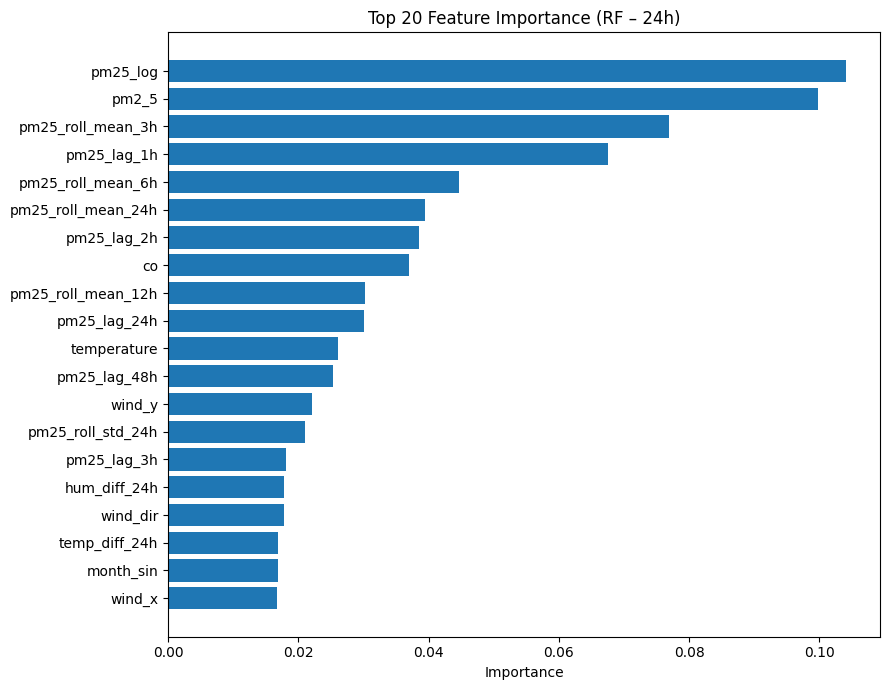

In [61]:
# Plot Feature Importance
TOP_N = 20

plt.figure(figsize=(9, 7))
plt.barh(
    importance_df.head(TOP_N)["feature"],
    importance_df.head(TOP_N)["importance"]
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title(f"Top {TOP_N} Feature Importance ({model_type} – 24h)")
plt.tight_layout()
plt.show()

In [63]:
# SHAP Analysis
print("\nRunning SHAP analysis...")

# Sample for performance
X_sample = X.sample(
    n=min(500, len(X)),
    random_state=42
)

explainer = shap.TreeExplainer(base_estimator)
shap_values = explainer.shap_values(X_sample)


Running SHAP analysis...


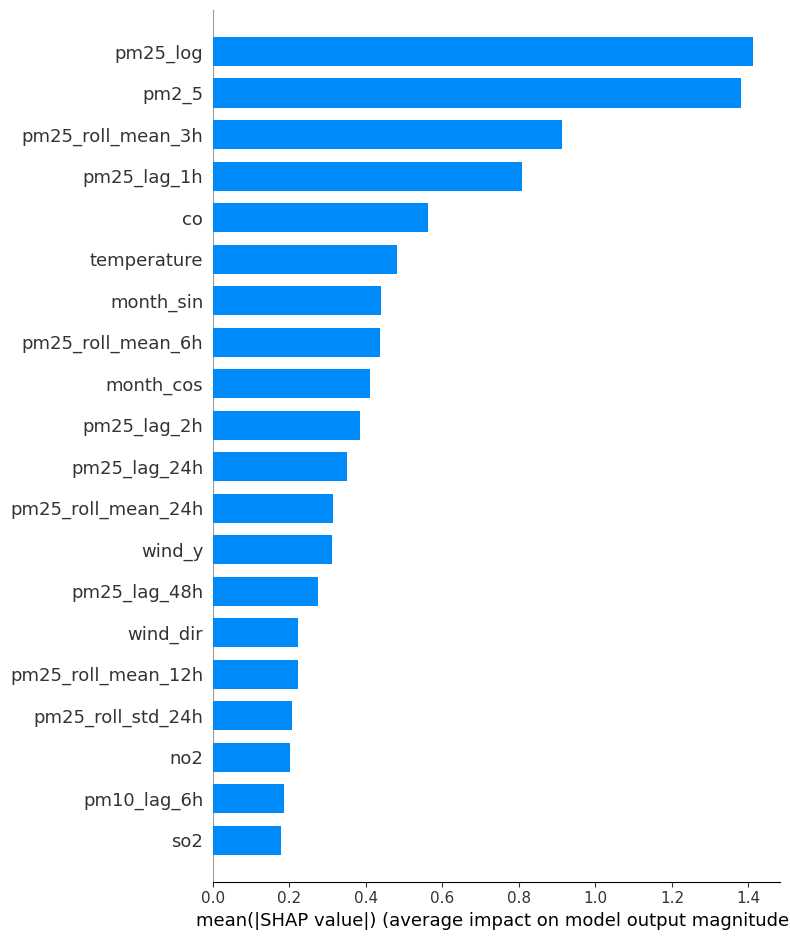

In [65]:
# Global importance
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="bar",
    max_display=20
)

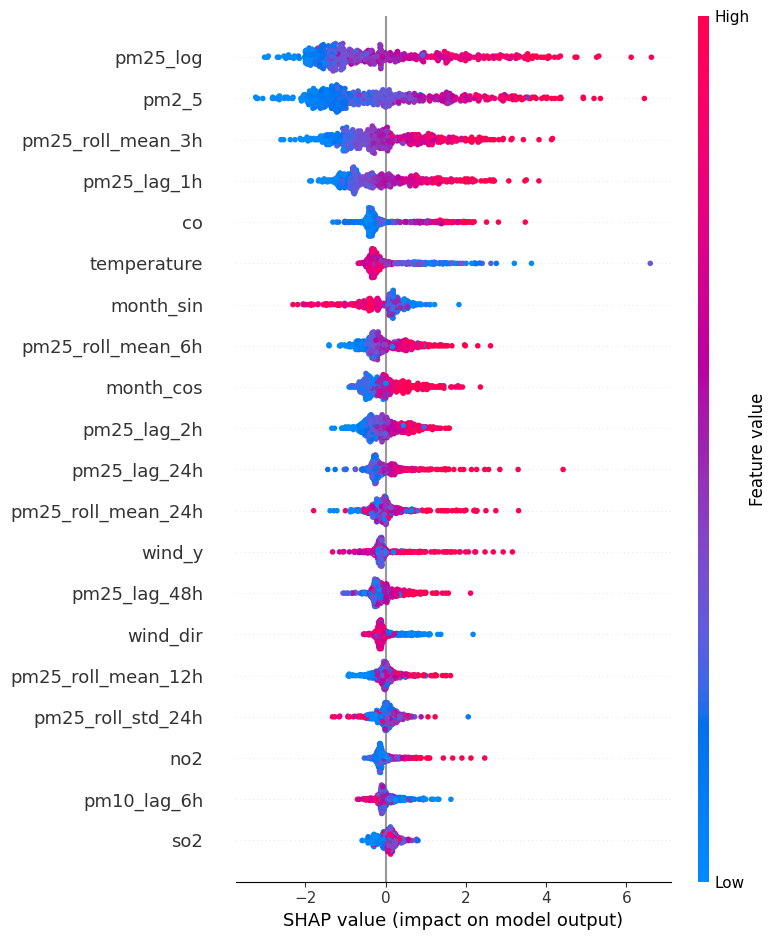

In [67]:
# Detailed impact
shap.summary_plot(
    shap_values,
    X_sample,
    max_display=20
)